# Generate family size fingerprint from per molecule h5 file

In [2]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
import scipy.sparse as sp
import logging
from collections import Counter

from fingerprint import SingleCellFingerprintBase
from commons import MoleculeInfo

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

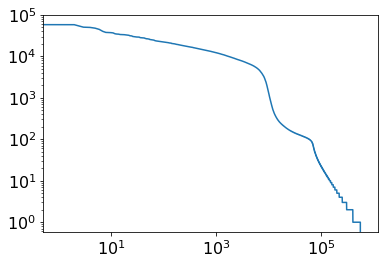

In [4]:
mol_info_h5_path = '/home/jupyter/data/10x/neuron_9k_molecule_info.h5'
# barcodes_to_include_path = '/home/jupyter/data/10x/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters/cell_barcodes.npy'
barcodes_to_include_path = None

mol_info = MoleculeInfo(mol_info_h5_path)
if barcodes_to_include_path is not None:
    barcodes_to_include = np.load(barcodes_to_include_path)
else:
    barcodes_to_include = None

sorted_umi_counts = list(map(operator.itemgetter(1), mol_info.sorted_total_umi_per_barcode_list))
plt.plot(sorted_umi_counts)
plt.xscale('log')
plt.yscale('log')

## Filtering molecules and generating the counts matrix

In [5]:
# select mappable molecules
mappable_molecule_indices = np.where(mol_info.gene_array != mol_info.unmappable_gene_idx)[0]

if barcodes_to_include is None: # select barcodes within a certain total mappable UMI range
    min_umi_count = 500
    max_umi_count = np.inf
    logging.warning(f"No barcode set provided -- choosing cell barcodes " +
                    f"with number of UMIs in range [{min_umi_count}, {max_umi_count}] ...")
    selected_molecule_indices = np.asarray([
        idx for idx in mappable_molecule_indices
        if min_umi_count <= mol_info.total_umi_per_barcode[mol_info.barcode_array[idx]] <= max_umi_count])
else: # choose the provided barcode set
    logging.warning(f"Barcode set is provided -- including all {len(barcodes_to_include)} barcodes in the set ...")
    barcodes_to_include_set = set(barcodes_to_include)
    selected_molecule_indices = np.asarray([
        idx for idx in mappable_molecule_indices if mol_info.barcode_array[idx] in barcodes_to_include_set])

selected_gene_array = mol_info.gene_array[selected_molecule_indices]
selected_read_array = mol_info.reads_array[selected_molecule_indices]
selected_barcode_array = mol_info.barcode_array[selected_molecule_indices]

# obtain the sparse counts matrix
n_genes = len(mol_info.gene_names_array)
n_cells = len(np.unique(mol_info.barcode_array[selected_molecule_indices]))
logging.warning(f'Number of cells: {n_cells}')

# index cell barcodes
cell_barcode_to_index = dict()
group_iter = itertools.groupby(mol_info.barcode_array[selected_molecule_indices])
i_cell = 0
for barcode, grouper in group_iter:
    cell_barcode_to_index[barcode] = i_cell
    i_cell += 1

# generate the sparse counts matrix
data = np.ones((len(selected_molecule_indices),), dtype=np.int)
cell_index = [cell_barcode_to_index[barcode] for barcode in mol_info.barcode_array[selected_molecule_indices]]
gene_index = mol_info.gene_array[selected_molecule_indices].tolist()
coo_counts_matrix = sp.coo_matrix((data, (cell_index, gene_index)), shape=(n_cells, n_genes))
csr_counts_matrix = coo_counts_matrix.tocsr()
csc_counts_matrix = coo_counts_matrix.tocsc()

# average observed gene expression per cell
mean_gene_expr = np.asarray(np.sum(csc_counts_matrix, axis=0)).flatten() / n_cells

# gene indices sorted by expression in selected molecules
sorted_genes_by_expr = list(map(
    operator.itemgetter(0),
    sorted(list(Counter(selected_gene_array).items()),
           key=operator.itemgetter(1),
           reverse=True)))

## Generating the single-cell family-size fingerprint

In [8]:
fs_mean = np.mean(selected_read_array)
fs_std = np.std(selected_read_array)
max_fs = int(np.ceil(fs_mean + 5 * fs_std))
logging.warning(f'Maximum family size was set to {max_fs}')

# what fraction of molecules have larger family size?
outlier_frac = np.sum(selected_read_array > max_fs) / len(selected_molecule_indices)
logging.warning(f'Fraction of molecules with larger family size: {outlier_frac:.5f}')

# generate an empty single-cell fingerprint instance
single_cell_fingerprint = SingleCellFingerprintBase(
    gene_idx_list=list(i_gene for i_gene in range(n_genes)),
    max_family_size=max_fs)

# populate
group_iter = itertools.groupby(enumerate(selected_barcode_array), key=operator.itemgetter(1))
for barcode, grouper in group_iter:
    i_cell = cell_barcode_to_index[barcode]
    indices = list(map(operator.itemgetter(0), grouper))
    first_index = indices[0]
    last_index = indices[-1]
    c_gene_array = selected_gene_array[first_index:last_index]
    
    # note: 0 means 1 read, 1 means 2 reads, etc.
    c_reads_array = np.clip(selected_read_array[first_index:last_index], a_min=None, a_max=max_fs) - 1
    c_fingerprint_matrix = sp.coo_matrix(
        (np.ones_like(c_gene_array), (c_gene_array, c_reads_array)),
        shape=(n_genes, max_fs)).tocsr()
    single_cell_fingerprint._add_new_barcode(barcode, c_fingerprint_matrix)
    
    if i_cell % 1_000 == 0:
        logging.warning(f'Processing cell {i_cell + 1}/{n_cells}...')

## Save to disk (optional)

In [9]:
single_cell_fingerprint.save('/home/jupyter/data/10x/neuron_9k_sc_fingerprint.pkl')